In [ ]:
!pip install kora -q
from kora import drive
drive.link_nbs()

     |████████████████████████████████| 57 kB 2.3 MB/s 
     |████████████████████████████████| 60 kB 8.0 MB/s 
Mounted at /content/drive


In [ ]:
import utils

importing Jupyter notebook from /nbs/utils.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from keras.applications.efficientnet import EfficientNetB0
from keras.models import Model, Sequential
from keras.layers import TimeDistributed, Input, MaxPooling3D, LSTM, Dense, Conv3D, Conv2D, BatchNormalization, Flatten, Dropout, Convolution2D, Activation, MaxPooling2D, GlobalAveragePooling2D
from keras import losses
import numpy as np
from keras import models

In [ ]:
""" Global variables"""
NUM_CLASSES = 4
EPOCHS = 10
INSTACK = 16
IMG_SIZE = (224, 224)
LEN_TRAIN = 85
LEN_TEST = 98


In [ ]:
""" Load train generators """

train_gen, val_gen, test_gen = utils.loadOFdatagens()

StopIteration exception: 
length data_files:  85
len data_list :  85
StopIteration exception: 
length data_files:  100
len data_list :  98
StopIteration exception: 
length data_files:  15
len data_list :  15
Success!


In [ ]:
from keras.layers.pooling import GlobalAveragePooling3D
def build_OF_model(input_shape= (INSTACK,IMG_SIZE[0],IMG_SIZE[1],3),num_classes=NUM_CLASSES):
  
    model = Sequential()

    model.add(Conv3D(32, kernel_size=3, input_shape=input_shape, padding='same', activation='relu'))
    model.add(MaxPooling3D(pool_size=2))
    model.add(BatchNormalization(momentum=0.9))

    model.add(Conv3D(32, kernel_size=3, padding='same', activation='relu'))  #kernel_regularizer='l1_l2'
    model.add(MaxPooling3D(pool_size=2, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    
    model.add(Dropout(0.2))

    model.add(Conv3D(64, kernel_size=3, padding='same', activation='relu')) # kernel_regularizer='l1_l2'
    model.add(MaxPooling3D(pool_size=2, padding='same'))
    model.add(BatchNormalization(momentum=0.9))

    model.add(Conv3D(128, kernel_size=3, padding='same', activation='relu')) # kernel_regularizer='l1_l2'
    model.add(MaxPooling3D(pool_size=2, padding='same'))
    model.add(BatchNormalization(momentum=0.9))

    model.add(Dropout(0.2))

    model.add(Conv3D(128, kernel_size=3, padding='same', activation='relu')) # kernel_regularizer='l1_l2'
    model.add(BatchNormalization(momentum=0.9))
    model.add(MaxPooling3D(pool_size=2, padding='same'))
    
    model.add(GlobalAveragePooling3D()) #Flatten layer
    model.add(Dense(512, activation='relu'))

    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax', name='pred')) #Output layer


    model.compile(loss='categorical crossentropy', optimizer='Adam', metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
""" Instantiating and compiling model """
of_model = build_OF_model((INSTACK, IMG_SIZE[0], IMG_SIZE[1], 1), NUM_CLASSES)
of_model.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=["accuracy"])
of_history = of_model.fit(train_gen,epochs= EPOCHS, steps_per_epoch = LEN_TRAIN, validation_data=val_gen, validation_steps=15 , verbose=1) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 224, 224, 32)  896       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 112, 112, 32)  0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 8, 112, 112, 32)  128       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 112, 112, 32)   27680     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 56, 56, 32)    0         
 3D)                                                             
                                                        

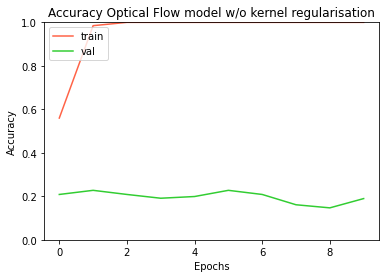

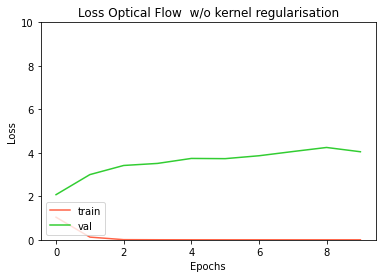

In [ ]:
""" Plotting results """
plotAccuracy("Accuracy Optical Flow model w/o kernel regularisation", of_history.history['accuracy'], of_history.history['val_accuracy'])
plotLoss("Loss Optical Flow  w/o kernel regularisation", of_history.history['loss'], of_history.history['val_loss'])

In [ ]:
of_model.save_weights('OF_weights_nokernelreg.h5')
of_model.save("OF_model_nokernelreg", save_format = 'tf', include_optimizer=True)

In [ ]:
# of_model.save_weights('OF_weights.h5')
# of_model.save("OF_model", save_format = 'tf', include_optimizer=True)

In [ ]:
""" Plotting results """
utils.plotAccuracy("Accuracy Optical Flow model", of_history.history['accuracy'], of_history.history['val_accuracy'])
utils.plotLoss("Loss Optical Flow model", of_history.history['loss'], of_history.history['val_loss'])

In [ ]:
#Zip and download the model
!zip -r /content/OF_model.zip /content/OF_model
from google.colab import files
files.download("OF_model.zip")

In [ ]:
# https://medium.com/@anuj_shah/creating-custom-data-generator-for-training-deep-learning-models-part-3-c239297cd5d6
# https://medium.com/swlh/building-a-custom-keras-data-generator-to-generate-a-sequence-of-videoframes-for-temporal-analysis-e364e9b70eb

In [ ]:
""" Checking data to see that data generator loads data as expected """
x, y = next(val_gen)
print("x shape: ", x.shape)
print("y shape: ", y.shape)

x_0 = x[0]
y_0 = y[0]
print("x_0 shape: ", x_0.shape)
print("y_0 shape: ", y_0.shape)

num_of_images=16
fig=plt.figure(figsize=(8,8)) 
plt.title(f"one sample with {num_of_images} frames ; activity:{y_0}")
subplot_num = int(np.ceil(np.sqrt(num_of_images)))
for i in range(int(num_of_images)):
    ax = fig.add_subplot(subplot_num, subplot_num, i+1)
    #ax.imshow(output_image[0,:,:,i],interpolation='nearest' ) #to see the first filter
    ax.imshow(x_0[i,:,::-1])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

In [ ]:
""" Load trained model and evaluate """
path_OF_model = "/content/drive/MyDrive/OF_model"
trained_model = models.load_model(path_OF_model)
trained_model.summary()

In [ ]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    try:
        from keras import backend as K
    except:
        from keras import backend as K

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

In [ ]:
get_model_memory_usage(17, trained_model)

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = of_model.evaluate(test_gen, steps=LEN_TEST)
print("test loss, test acc:", results)


Evaluate on test data
98/98 [==============================] - 49s 505ms/step - loss: 3.9930 - accuracy: 0.3333
test loss, test acc: [3.993021249771118, 0.3333333432674408]
